# PART 1 - COLLECTING DATA

### In this part of the notebook, we are trying to collect the data that has been generated by MC3000 Monitor V1.05 (the default application for data logging, used for SKYRC MC3000 Battery Analyzer), for the following estimation, information regarding the temperature and capacity of tested Lithium Ion Battery (which is XTAR RCR123A) is collected, and processed into two datasets, which are The Correlation Between Maximum Temperature and Maximum Battery Capacity of Lithium Ion Battery in Charging State and Discharging State.

In [1]:
# Install required libraries.

!pip install pandas
!pip install glob2
!pip install grpcio
!pip install -q tensorflow==2.1
!pip install -q keras==2.3.1

In [1]:
# Loading required libraries.
# Adding path to the data files and prepare to load them.

import pandas as pd
import glob2
import numpy as np

path = r'C:\Users\LENOVO\OneDrive\Desktop\MC3000_Monitor_V1.05'
dataset_path = r'C:\Users\LENOVO\OneDrive\Desktop'
file_name = glob2.glob(path + "/*.csv")

chg_data_set = []
dsc_data_set = []
cap_data_set = []

In [2]:
# Split the data into 2 parts, the charging part and discharging part.
# Determine the maximum temperature recorded for each part in the following cycle.
# Construct two dataframes consisting the maximum temperature and maximum capacity of each cycle for each part.

for filename in file_name:
    raw_data = pd.read_csv(filename, index_col=None, header=0, sep=';')
    chg_data, dsc_data = np.split(raw_data, [int(.3*len(raw_data))])
    max_cap_data = raw_data.max()
    max_chg_data = chg_data.max()
    max_dsc_data = dsc_data.max()
    cap_data_set.append(max_cap_data)
    chg_data_set.append(max_chg_data)
    dsc_data_set.append(max_dsc_data)

In [3]:
# Take only the necessities values from the dataset.
# Forge into 2 datasets, Comparison of Maximum Temperature to Maximum Capacity from each Cycles.
# From the Charging Part and the Discharging Part.

cap_data_frame = pd.DataFrame(cap_data_set, index=None)
chg_data_frame = pd.DataFrame(chg_data_set, index=None)
dsc_data_frame = pd.DataFrame(dsc_data_set, index=None)
cap_clean_data = cap_data_frame[['Capacity(mAh)']]
chg_clean_data = chg_data_frame[['Batt.Temp(C)']]
dsc_clean_data = dsc_data_frame[['Batt.Temp(C)']]

charge_dataset = pd.concat([cap_clean_data, chg_clean_data], axis='columns', join='inner')
discharge_dataset = pd.concat([cap_clean_data, dsc_clean_data], axis='columns', join='inner')
display(charge_dataset)
print("Comparison of Maximum Temperature to Maximum Capacity from each Cycles - Charging Part")
display(discharge_dataset)
print("Comparison of Maximum Temperature to Maximum Capacity from each Cycles - Discharging Part")

,Capacity(mAh),Batt.Temp(C)
0,709.1,41.9
1,708.5,44.0
2,706.4,45.2
3,703.5,40.4
4,703.3,39.5
...,...,...
595,60.5,31.7
596,62.2,32.5
597,56.4,31.6
598,59.9,29.0


Comparison of Maximum Temperature to Maximum Capacity from each Cycles - Charging Part


,Capacity(mAh),Batt.Temp(C)
0,709.1,33.5
1,708.5,34.9
2,706.4,36.0
3,703.5,35.7
4,703.3,35.2
...,...,...
595,60.5,32.2
596,62.2,32.9
597,56.4,31.5
598,59.9,29.7


Comparison of Maximum Temperature to Maximum Capacity from each Cycles - Discharging Part


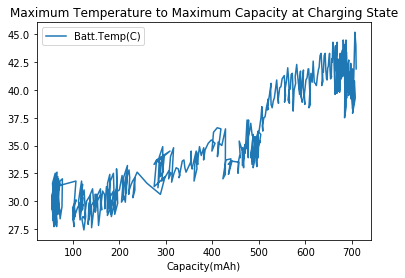

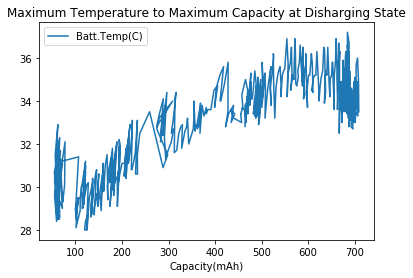

In [4]:
# Use this section only for plotting the given dataset to figure the data visually.

charge_dataset.plot(x='Capacity(mAh)', y='Batt.Temp(C)', title="Maximum Temperature to Maximum Capacity at Charging State")
discharge_dataset.plot(x='Capacity(mAh)', y='Batt.Temp(C)', title="Maximum Temperature to Maximum Capacity at Disharging State")

In [5]:
# Use this section to generate the dataset to desktop in csv.

charge_dataset.to_csv(r'C:\Users\LENOVO\OneDrive\Desktop\charge_dataset.csv', sep=';', encoding='utf-8', header='true', index=False)
discharge_dataset.to_csv(r'C:\Users\LENOVO\OneDrive\Desktop\discharge_dataset.csv', sep=';', encoding='utf-8', header='true', index=False)
print("Dataset has been generated at " + dataset_path)

Dataset has been generated at C:\Users\LENOVO\OneDrive\Desktop


# PART 2 - PREPROCESSING DATA

### In this part of the notebook, after we have succeeded to generate the dataset, the next step that needed to be done is to make the dataset suitable for training and testing process for the neural network builds. The first step is to condition the dataset for the temperature change to be more pronounced (dataset in the Charging State is used), since the estimation is based on the Maximum Temperature of the battery, therefore the processed part is the information regarding to the battery temperature. The second step is to scale the value into the range from zero to one (since LSTM network is sensitive to big numbers). And the third step is to process the dataset into a time series sequence for the network to train.

In [5]:
# Loading the generated csv file into the environment.
# Seperate the Capacity and Battery Temperature into two dataframes.

dataset = pd.read_csv(r'C:\Users\LENOVO\OneDrive\Desktop\charge_dataset.csv', sep=';')
cap_dataset = dataset[['Capacity(mAh)']]
tmp_dataset = dataset[['Batt.Temp(C)']]

i = 1
len_dataset = []
for i in range(len(dataset.index)):
    len_dataset.append(i)
    i += 1

cap_dataset['Cycle'] = len_dataset
tmp_dataset['Cycle'] = len_dataset

cap_dataset_plot = cap_dataset
tmp_dataset_plot = tmp_dataset

dummy_cap = cap_dataset_plot
dummy_tmp = tmp_dataset_plot

display(cap_dataset)
print("Battery Maximum Capacity Records at the Charging Part")
display(tmp_dataset)
print("Battery Maximum Temperature Records at the Charging Part")

,Capacity(mAh),Cycle
0,709.1,0
1,708.5,1
2,706.4,2
3,703.5,3
4,703.3,4
...,...,...
595,60.5,595
596,62.2,596
597,56.4,597
598,59.9,598


Battery Maximum Capacity Records at the Charging Part


,Batt.Temp(C),Cycle
0,41.9,0
1,44.0,1
2,45.2,2
3,40.4,3
4,39.5,4
...,...,...
595,31.7,595
596,32.5,596
597,31.6,597
598,29.0,598


Battery Maximum Temperature Records at the Charging Part


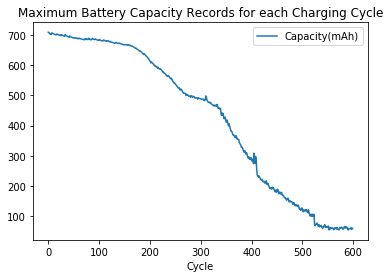

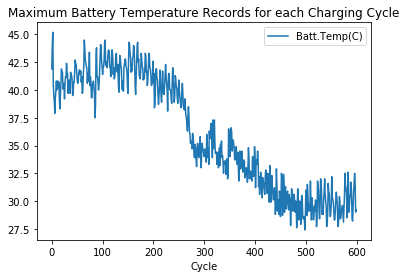

In [6]:
# Use this section only for plotting the given dataset to figure the data visually.

cap_dataset_plot.plot(x='Cycle', y='Capacity(mAh)', title = "Maximum Battery Capacity Records for each Charging Cycle")
tmp_dataset_plot.plot(x='Cycle', y='Batt.Temp(C)', title = "Maximum Battery Temperature Records for each Charging Cycle")

In [7]:
# Recreating the raw dataset dataframe.

battery_capacity_df = dummy_cap
battery_capacity_df.set_index('Cycle',inplace=True)
display(battery_capacity_df)

battery_temperature_df = dummy_tmp
battery_temperature_df.set_index('Cycle',inplace=True)
display(battery_temperature_df)

,Capacity(mAh)
Cycle,
0,709.1
1,708.5
2,706.4
3,703.5
4,703.3
...,...
595,60.5
596,62.2
597,56.4


,Batt.Temp(C)
Cycle,
0,41.9
1,44.0
2,45.2
3,40.4
4,39.5
...,...
595,31.7
596,32.5
597,31.6


In [8]:
# Decompose the raw dataset into Trend, Seasonal, and Residual/Noise using seasonal_decompose tool.

from statsmodels.tsa.seasonal import seasonal_decompose

cap_dataset.reset_index(inplace=True)
tmp_dataset.reset_index(inplace=True)
cap_dataset.set_index('Cycle',inplace=True)
tmp_dataset.set_index('Cycle',inplace=True)
cap_dataset.index = pd.to_datetime(cap_dataset.index)
tmp_dataset.index = pd.to_datetime(tmp_dataset.index)

defcomp = 30

cap_decomposed = seasonal_decompose(cap_dataset['Capacity(mAh)'], model='additive', period=defcomp)
tmp_decomposed = seasonal_decompose(tmp_dataset['Batt.Temp(C)'], model='additive', period=defcomp)

cap_trend = pd.DataFrame(cap_decomposed.trend)
cap_trend = cap_trend.dropna().reset_index()
cap_trend = cap_trend['trend']
cap_seasonal = pd.DataFrame(cap_decomposed.seasonal)
cap_seasonal = cap_seasonal.dropna().reset_index()
cap_seasonal = cap_seasonal['seasonal']
cap_resid = pd.DataFrame(cap_decomposed.resid)
cap_resid = cap_resid.dropna().reset_index()
cap_resid = cap_resid['resid']

tmp_trend = pd.DataFrame(tmp_decomposed.trend)
tmp_trend = tmp_trend.dropna().reset_index()
tmp_trend = tmp_trend['trend']
tmp_seasonal = pd.DataFrame(tmp_decomposed.seasonal)
tmp_seasonal = tmp_seasonal.dropna().reset_index()
tmp_seasonal = tmp_seasonal['seasonal']
tmp_resid = pd.DataFrame(tmp_decomposed.resid)
tmp_resid = tmp_resid.dropna().reset_index()
tmp_resid = tmp_resid['resid']

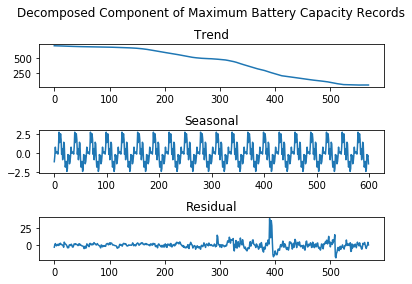

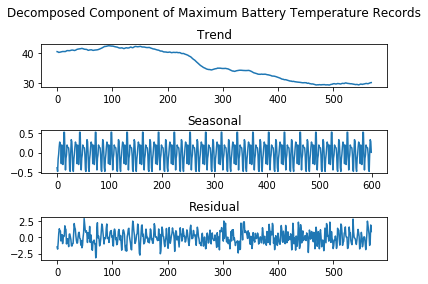

In [9]:
# Use this section only for plotting the given dataset to figure the data visually.

import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(3)
fig1.suptitle('Decomposed Component of Maximum Battery Capacity Records')
axs1[0].plot(cap_trend)
axs1[0].set_title("Trend")
axs1[1].plot(cap_seasonal)
axs1[1].set_title("Seasonal")
axs1[2].plot(cap_resid)
axs1[2].set_title("Residual")
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.85,
                    wspace=1,
                    hspace=1)

fig2, axs2 = plt.subplots(3)
fig2.suptitle('Decomposed Component of Maximum Battery Temperature Records')
axs2[0].plot(tmp_trend)
axs2[0].set_title("Trend")
axs2[1].plot(tmp_seasonal)
axs2[1].set_title("Seasonal")
axs2[2].plot(tmp_resid)
axs2[2].set_title("Residual")
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.85,
                    wspace=1,
                    hspace=1)

In [10]:
# In this section, we are going to reconstruct the Capacity and Temperature Records.
# For the Capacity Records, we only need the Trend.
# This is due to the nature of battery capacity degradation that should be degraded on every single cycle.
# Therefore the fluctuative value in any degree is inevitable.
# For the Temperature Records, we are also going to need the Trend.
# This is to reduce the variable of estimation and increasing the estimation accuracy.

i = 1
len_cap = []
for i in range(len(cap_trend)):
    len_cap.append(i)
    i += 1

capacity_cycle = pd.DataFrame(cap_trend)
capacity_cycle = capacity_cycle.rename(columns={'trend': 'Capacity(mAh)'})
capacity_cycle['Cycle'] = len_cap
capacity_cycle.set_index('Cycle',inplace=True)

i = 1
len_tmp = []
for i in range(len(tmp_trend)):
    len_tmp.append(i)
    i += 1

#------------------------- USE THIS PART IF YOU WANT TO INCORPORATE THE SEASONAL VALUE AS WELL ----------------------------

#l_l = int(defcomp/2)
#h_l = int(len(tmp_seasonal)-(defcomp/2))
#tmp_seas = tmp_seasonal[l_l:h_l]
#tmp_seas = pd.DataFrame(tmp_seas)
#tmp_seas.reset_index(inplace=True)
#tmp_seas = tmp_seas['seasonal']
#tmp_cyc = tmp_seas + tmp_trend

#--------------------------------------------------------------------------------------------------------------------------

temperature_cycle = pd.DataFrame(tmp_trend)
temperature_cycle = temperature_cycle.rename(columns={'trend':'Batt.Temp(C)'})
temperature_cycle['Cycle'] = len_cap
temperature_cycle.set_index('Cycle',inplace=True)

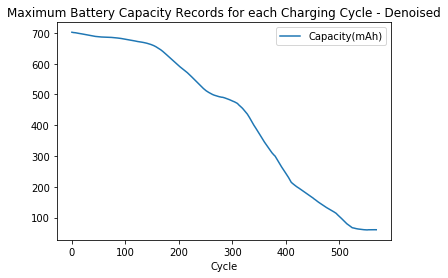

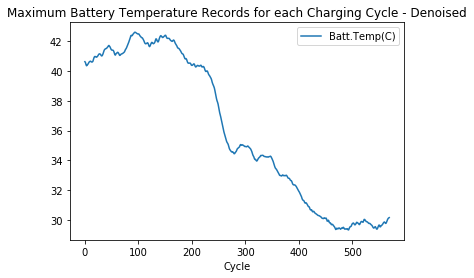

In [11]:
# Use this section only for plotting the given dataset to figure the data visually.

capacity_cycle.plot(title = "Maximum Battery Capacity Records for each Charging Cycle - Denoised")
temperature_cycle.plot(title = "Maximum Battery Temperature Records for each Charging Cycle - Denoised")

In [12]:
# From the existed battery temperature dataset, we are going to seperate the dataset into 2 arrays.
# Which are the training dataset and the initial testing dataset.

test_size = 370
size_temp = len(temperature_cycle) - test_size

train_temp = temperature_cycle.iloc[:size_temp]
test_temp = temperature_cycle.iloc[size_temp:]

train_temp_array = train_temp.to_numpy
test_temp_array = test_temp.to_numpy

In [13]:
# Registering MinMaxScaler to the environment.
# Applying MinMaxScaler to the dataset to picture the information with the smaller number 
# This is needed to comply with the sensitivity of LSTM Network to big numbers

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(temperature_cycle)
temp_scaled = scaler.transform(temperature_cycle)
train_temp_scaled = scaler.transform(train_temp)
test_temp_scaled = scaler.transform(test_temp)

df_temp_scaled = pd.DataFrame(temp_scaled)
temp_array = scaler.inverse_transform(temp_scaled)

In [14]:
# Generate the processed data into time series sequence to be able to used for the LSTM Network.
# This method will enable network to estimate the next value of the (n-long) sequence.
# While n is the length of each sequence needed to estimate the next value which is user defined.

from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 20
n_features = 1
generator = TimeseriesGenerator(temp_scaled, temp_scaled, length=n_input, batch_size=1)

X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Using TensorFlow backend.


Given the Array: 
[0.85097546 0.84745123 0.837382   0.83045941 0.83222152 0.83574575
 0.83977344 0.84493392 0.84946507 0.85173065 0.85349276 0.8529893
 0.84996853 0.84921334 0.84984267 0.8529893  0.86167401 0.87086218
 0.87627439 0.8776589 ]
Predict this y: 
 [[0.87640025]]


# PART 3 - BUILDING LSTM NEURAL NETWORK

### In this part of the notebook, after we already have the processed dataset for training and testing process, we are going to proceed to the next step. To build the Neural Network, we are going to use the LSTM module from the Keras Library. In this specific part, we will manage to build, train, and fit the network before put it into the tests.

In [15]:
# Importing relevant Keras Libraries as the foundation of building Neural Network.

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM

In [50]:
# Building Neural Network Model.

model = Sequential()
model.add(LSTM(20, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Fitting the training dataset into the neural network build.

model.fit(generator, epochs = 30)

Epoch 1/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0433
Epoch 2/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0038
Epoch 3/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0024
Epoch 4/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0026
Epoch 5/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0038
Epoch 6/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0031
Epoch 7/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0028
Epoch 8/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0029
Epoch 9/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0026
Epoch 10/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0025
Epoch 11/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0036
Epoch 12/30
550/550 [==============================] - 3s 6ms/step - loss: 0.0024
Epoch 13/30
550/550 [====

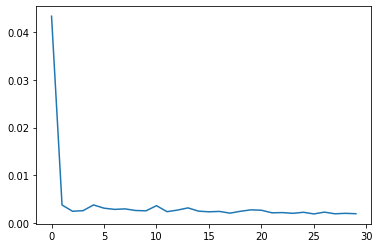

In [52]:
# Use this section only for plotting loss per epoch to figure the data visually.

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [17]:
# Initiating to test the network with testing dataset.

last_train_batch = temp_scaled[:n_input]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
init_val_pred = model.predict(last_train_batch)
init_val_real = test_temp_scaled[0]
print(init_val_pred)
print(init_val_real)

[[0.8430571]]
[0.83222152]


In [18]:
# Do the testing process.

test_predictions = []


first_eval_batch = temp_scaled[:n_input]
current_batch = first_eval_batch.reshape(1, n_input, n_features)

print(train_temp_scaled.shape)
print(first_eval_batch.shape)

for i in range(len(test_temp)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
print(current_batch.shape)

(200, 1)
(20, 1)
(1, 20, 1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


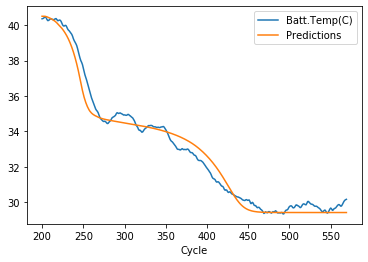

In [19]:
# Inverting the MinMax scaled values into its original values.

true_predictions = scaler.inverse_transform(test_predictions)
test = test_temp
test['Predictions'] = true_predictions
test.plot()

In [20]:
# Evaluating the Neural Network build by looking at the MAPE as a measure of performance.

from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test['Batt.Temp(C)'],test['Predictions'])
mape_perc = mape*100
print("The estimated error occured from the predictions compared to the original data is " + str(mape_perc) + "%.")

The estimated error occured from the predictions compared to the original data is 1.1526037355193968%.


In [79]:
# If the model has achieved sufficient accuracy for the estimation, then we could save the model to the disk.

model.save(r'C:\Users\LENOVO\OneDrive\Desktop\weight_LSTM')

In [16]:
# Use this line instead if you want to load the trained model.

import keras
model = keras.models.load_model(r'C:\Users\LENOVO\OneDrive\Desktop\weight_LSTM')

# PART 4 - UTILIZING LSTM NEURAL NETWORK

### In this part of the notebook, we are going to use the trained network to estimate the number of cycles are available using the chopped dataset in different phase. To estimate the available cycle remaining, the network has to be able to estimate for the entire length of the dataset. This estimation result is then clipped at the lowest point, according to the lowest point of the original (scaled and denoised) dataset which is also the last recorded value that flagged as the very end of the dataset. From this prediction result, we could see how many cycles are still available and trace it back to the cycle-capacity dataset to see the battery capacity accordingly.

In [21]:
# Preparing the clipped dataset (data that will be kept are in the range from the 101st to the 201th).

clipped_df = temperature_cycle.iloc[201:221]
clipped_df_scaled = scaler.transform(clipped_df)
clipped_df_arr = pd.DataFrame(clipped_df_scaled)
clipped_df_len = len(clipped_df)

In [22]:
# See the first value from the real data and the prediction result to see the overall similarities in result.
# Buff the real data with difference first value to get the best result.

last_train_batch_a = clipped_df_arr[0:]
last_train_batch_a = last_train_batch_a.values.reshape((1, n_input, n_features))
init_val_pred_a = model.predict(last_train_batch_a)
init_val_pred_a = init_val_pred_a[0]
init_val_pred_a = init_val_pred_a[0]
init_val_real_a = clipped_df_scaled[clipped_df_len-1]
init_val_real_a = init_val_real_a[0]
print(init_val_pred_a)
print(init_val_real_a)

0.80845666
0.8249213341724353


In [23]:
# Do the testing process.

test_predictions_a = []

first_eval_batch_a = clipped_df_scaled[-n_input:]
current_batch_a = first_eval_batch_a.reshape(1, n_input, n_features)

print(clipped_df_scaled.shape)
print(first_eval_batch_a.shape)

for i in range(len(clipped_df)):
    current_pred_a = model.predict(current_batch_a)[0]
    test_predictions_a.append(current_pred_a)
    current_batch_a = np.append(current_batch_a[:,1:,:],[[current_pred_a]], axis=1)
    
print(current_batch_a.shape)

(20, 1)
(20, 1)
(1, 20, 1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


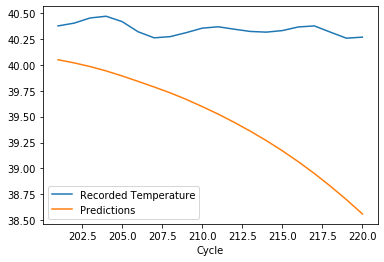

In [24]:
# Inverting the MinMax scaled values into its original values.

validator_df = temperature_cycle.iloc[201:221]
true_predictions_a = scaler.inverse_transform(test_predictions_a)
true_predictions_df = validator_df
true_predictions_df['Predictions'] = true_predictions_a

true_predictions_df = true_predictions_df.rename(columns={'Batt.Temp(C)':'Recorded Temperature'})
true_predictions_df.plot()

In [25]:
# Evaluating the Neural Network build by looking at the MAPE as a measure of performance.

mape_a = mean_absolute_percentage_error(true_predictions_df['Recorded Temperature'],true_predictions_df['Predictions'])
mape_perc_a = mape_a*100
print("The estimated error occured from the predictions compared to the original data is " + str(mape_perc_a) + "%.")

The estimated error occured from the predictions compared to the original data is 2.170563523651905%.


In [26]:
# Do the continous testing process for the longer entries.

test_predictions_b = []

first_eval_batch_b = clipped_df_scaled[-n_input:]
current_batch_b = first_eval_batch_b.reshape(1, n_input, n_features)

print(clipped_df_scaled.shape)
print(first_eval_batch_b.shape)

for i in range(len(temperature_cycle)):
    current_pred_b = model.predict(current_batch_b)[0]
    test_predictions_b.append(current_pred_b)
    current_batch_b = np.append(current_batch_b[:,1:,:],[[current_pred_b]], axis=1)
    
print(current_batch_b.shape)

(20, 1)
(20, 1)
(1, 20, 1)


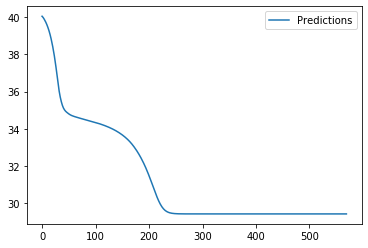

In [27]:
# Inverting the MinMax scaled values into its original values.

true_predictions_b = scaler.inverse_transform(test_predictions_b)
true_predictions_b = pd.DataFrame(true_predictions_b)
true_predictions_b = true_predictions_b.rename(columns={0:'Predictions'})
true_predictions_b.plot()

In [28]:
# Checking the minimum value of the temperature dataset (scaled) and the prediction results.

min_temp_org = temperature_cycle.min()
print(min_temp_org)

min_temp_prd = true_predictions_b.min()
print(min_temp_prd)

Batt.Temp(C)    29.343333
dtype: float64
Predictions    29.422008
dtype: float64


In [29]:
# Generating the minimum threshold to clip the prediction results.

temp_threshold = float(min_temp_prd)
temp_threshold = temp_threshold + 0.005
temp_threshold = round(temp_threshold, 2)
temp_threshold

29.43

In [30]:
# Locating the dataset minimum value in the prediction results and take out the rows from that value and below.

prediction_clipped = true_predictions_b.loc[true_predictions_b['Predictions'] >= temp_threshold]
prediction_clipped_len = len(prediction_clipped)
prediction_clipped_len

254

In [31]:
# Look for the smallest value in the original dataset.

temp_org_min = min(temp_array)
temp_org_min = float(temp_org_min)
temp_org_min

29.34333333333333

In [32]:
# Look for the index of the smallest value in the original dataset.

min_temp_org_index = temperature_cycle.reset_index()
min_temp_org_index = min_temp_org_index['Cycle'].where(min_temp_org_index['Batt.Temp(C)'] <= (temp_org_min + 0.001))
min_temp_org_index = pd.DataFrame(min_temp_org_index)
min_temp_org_index = min_temp_org_index.dropna()
min_temp_org_index = int(min_temp_org_index['Cycle'].iloc[0])
min_temp_org_index

493

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


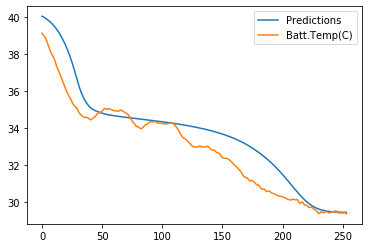

In [33]:
# Use this to compare the clipped estimation results and clipped source dataset visually.

min_temp_org_index_df = temperature_cycle.iloc[:min_temp_org_index]
min_temp_org_index_clipped = min_temp_org_index_df.iloc[-prediction_clipped_len:]
min_temp_org_index_clipped = min_temp_org_index_clipped.reset_index()
min_temp_org_index_comp = prediction_clipped
min_temp_org_index_comp['Batt.Temp(C)'] = min_temp_org_index_clipped['Batt.Temp(C)']
min_temp_org_index_comp.plot()

In [34]:
# Estimate the the current SoH (in mAh) of the battery, and compare it to the given dataset to calculate the
# Estimation Accuracy

temp_cyc_len = min_temp_org_index
current_temp_prd_len = temp_cyc_len-prediction_clipped_len
cap_cyc_arr = capacity_cycle.to_numpy()

current_cap_prd = cap_cyc_arr[current_temp_prd_len]
current_cap_real = cap_cyc_arr[221]
current_cap_prd = float(current_cap_prd)
current_cap_real = float(current_cap_real)

cap_cyc_max = float(capacity_cycle.max())
current_soh_prd = (current_cap_prd/cap_cyc_max)*100
current_soh_real = (current_cap_real/cap_cyc_max)*100

pred_error = (abs((current_cap_prd-current_cap_real)/current_cap_real))
pred_accuracy = (1-pred_error)*100

print("The recorded battery State of Health from the original data is " + str(current_soh_real) + "%.")
print("The estimated battery State of Health from the prediction result is " + str(current_soh_prd) + "%.")
print(" ")
print("The recorded battery capacity on the lowest temperature from the original data is " + str(current_cap_real) + " mAh.")
print("The estimated battery capacity from the prediction result is " + str(current_cap_prd) + " mAh.")
print("Therefore, the estimation accuracy is " + str(pred_accuracy) + "%.")

The recorded battery State of Health from the original data is 80.09528398853934%.
The estimated battery State of Health from the prediction result is 75.63065704173363%.
 
The recorded battery capacity on the lowest temperature from the original data is 562.3583333333333 mAh.
The estimated battery capacity from the prediction result is 531.0116666666667 mAh.
Therefore, the estimation accuracy is 94.42585540061941%.


# PART 5 - DESIGNING THE USER INTERFACE

### In this fifth and the last part of this notebook, we are going to design the page where this entire SoH Estimation applied and can be used as a proper tool. The entire design and application will be done using Gradio Web UI within the Jupyter environment.

In [43]:
# Preparing tests dataset that will be used to test the interface function.
# The dataset is prepared from the raw dataset within the first 200-300 and 300-400 cycles.

temp_f100 = temperature_cycle.iloc[1:101]
temp_f150 = temperature_cycle.iloc[51:151]
temp_f200 = temperature_cycle.iloc[101:201]
temp_f250 = temperature_cycle.iloc[151:251]
temp_f300 = temperature_cycle.iloc[201:301]
temp_f350 = temperature_cycle.iloc[251:351]
temp_f400 = temperature_cycle.iloc[301:401]
temp_f450 = temperature_cycle.iloc[351:451]
temp_f500 = temperature_cycle.iloc[401:501]

temp_f100.to_csv(r'C:\Users\LENOVO\OneDrive\Desktop\tempcyc_f100.csv', sep=';', encoding='utf-8', header='true', index=False)
temp_f150.to_csv(r'C:\Users\LENOVO\OneDrive\Desktop\tempcyc_f150.csv', sep=';', encoding='utf-8', header='true', index=False)
temp_f200.to_csv(r'C:\Users\LENOVO\OneDrive\Desktop\tempcyc_f200.csv', sep=';', encoding='utf-8', header='true', index=False)
temp_f250.to_csv(r'C:\Users\LENOVO\OneDrive\Desktop\tempcyc_f250.csv', sep=';', encoding='utf-8', header='true', index=False)
temp_f300.to_csv(r'C:\Users\LENOVO\OneDrive\Desktop\tempcyc_f300.csv', sep=';', encoding='utf-8', header='true', index=False)
temp_f350.to_csv(r'C:\Users\LENOVO\OneDrive\Desktop\tempcyc_f350.csv', sep=';', encoding='utf-8', header='true', index=False)
temp_f400.to_csv(r'C:\Users\LENOVO\OneDrive\Desktop\tempcyc_f400.csv', sep=';', encoding='utf-8', header='true', index=False)
temp_f450.to_csv(r'C:\Users\LENOVO\OneDrive\Desktop\tempcyc_f450.csv', sep=';', encoding='utf-8', header='true', index=False)
temp_f500.to_csv(r'C:\Users\LENOVO\OneDrive\Desktop\tempcyc_f500.csv', sep=';', encoding='utf-8', header='true', index=False)

In [35]:
# Importing load_model module from tensorflow.keras... instead of keras... to comply with the error.

import tensorflow.keras
df_model = tensorflow.keras.models.load_model(r'C:\Users\LENOVO\OneDrive\Desktop\weight_LSTM')

In [36]:
# Build the estimation function to be launched in the Gradio Interface.

def soh_estimation (csv_file):
    dataframe = pd.read_csv(csv_file.name, delimiter=';')
    
    #--------------------------- USE THIS PART ONLY IF THE DATASET GIVEN IS NOT CONDITIONED ------------------------------
    
    #dataframe_decomposed = seasonal_decompose(dataframe['Batt.Temp(C)'], model='additive', period=defcomp)
    #dataframe_trend = pd.DataFrame(dataframe_decomposed.trend)
    #dataframe_trend = dataframe_trend.dropna().reset_index()
    #dataframe_trend = dataframe_trend['trend']
    
    #i = 1
    #len_trend = []
    #for i in range(len(dataframe_trend)):
    #    len_trend.append(i)
    #    i += 1
    
    #dataframe_temp_cycle = pd.DataFrame(dataframe_trend)
    #dataframe_temp_cycle = dataframe_temp_cycle.rename(columns={'trend':'Batt.Temp(C)'})
    #dataframe_temp_cycle['Cycle'] = len_trend
    #dataframe_temp_cycle.set_index('Cycle',inplace=True)
    
    #----------------------------------------------------------------------------------------------------------------------
    
    dataframe_scaler = MinMaxScaler()
    dataframe_scaler.fit(temperature_cycle)
    dataframe_scaled = dataframe_scaler.transform(dataframe)
    
    dataframe_soh_predictions = []
    dataframe_batch_size = 20
    first_eval_batch_soh = dataframe_scaled[-dataframe_batch_size:]
    current_batch_soh = first_eval_batch_soh.reshape(1, n_input, n_features)

    for i in range(len(temperature_cycle)):
        current_pred_soh = df_model.predict(current_batch_soh)[0]
        dataframe_soh_predictions.append(current_pred_soh)
        current_batch_soh = np.append(current_batch_soh[:,1:,:],[[current_pred_soh]], axis=1)
    
    dataframe_soh_true_predictions = dataframe_scaler.inverse_transform(dataframe_soh_predictions)
    dataframe_soh_true_predictions = pd.DataFrame(dataframe_soh_true_predictions)
    dataframe_soh_true_predictions = dataframe_soh_true_predictions.rename(columns={0:'Predictions'})
    
    dataframe_min_temp_predictions = dataframe_soh_true_predictions.min()
    dataframe_treshold_temp_predictions = float(dataframe_min_temp_predictions)
    dataframe_treshold_temp_predictions = dataframe_treshold_temp_predictions + 0.005
    dataframe_treshold_temp_predictions = round(temp_threshold, 2)
    
    dataframe_soh_prediction_clipped = dataframe_soh_true_predictions.loc[dataframe_soh_true_predictions['Predictions'] >= dataframe_treshold_temp_predictions]
    dataframe_soh_prediction_clipped_len = len(dataframe_soh_prediction_clipped)
    
    dataframe_soh_current_capacity_len = temp_cyc_len-dataframe_soh_prediction_clipped_len
    dataframe_soh_current_capacity = cap_cyc_arr[dataframe_soh_current_capacity_len]
    dataframe_soh_current_capacity = float(dataframe_soh_current_capacity)
    dataframe_soh_current = (dataframe_soh_current_capacity/cap_cyc_max)*100
    
    output_str = "Your current battery capacity : " + str(round(dataframe_soh_current_capacity,2)) + "mAh                                        Your battery State of Health : " + str(round(dataframe_soh_current,2)) + "%"
    
    return(output_str)

In [1]:
# Installing required packages version to be able to use Gradio.

!pip install h11==0.12
!pip install httpcore==0.15.0
!pip install fsspec --upgrade --user

Requirement already up-to-date: fsspec in c:\users\lenovo\appdata\roaming\python\python37\site-packages (2022.11.0)


In [2]:
# Installing the required library to use Gradio Web UI.

!pip install gradio --upgrade --user

Requirement already up-to-date: gradio in c:\programdata\anaconda3\lib\site-packages (3.12.0)


In [37]:
# Establishing Gradio package into Jupyter environment.

import gradio as gr

In [38]:
# Constructing GUI.

iface = gr.Interface(fn = soh_estimation, 
                     inputs = gr.inputs.File(label = 'csv_file'), 
                     outputs="text",
                     title="Lithium-Ion Battery Diagnostics",
                     description="""This tool is designed specifically for XTAR CR123 Rechargeable Lithium-Ion Batteries. Utilizing LSTM Network trained with dataset taken with SKYRC MC3000 Universal Battery Charger & Analyzer. """)
iface.launch()

C:\ProgramData\Anaconda3\lib\site-packages\gradio\inputs.py:347: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
C:\ProgramData\Anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\ProgramData\Anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `keep_filename` parameter is deprecated, and it has no effect
  warnings.warn(value)


IMPORTANT: You are using gradio version 3.12.0, however version 3.14.0 is available, please upgrade.
--------
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\gradio\routes.py", line 298, in run_predict
    iterators=iterators,
  File "C:\ProgramData\Anaconda3\lib\site-packages\gradio\blocks.py", line 1007, in process_api
    result = await self.call_function(fn_index, inputs, iterator, request)
  File "C:\ProgramData\Anaconda3\lib\site-packages\gradio\blocks.py", line 849, in call_function
    block_fn.fn, *processed_input, limiter=self.limiter
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "C:\ProgramData\Anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-36-7d3533f6a09a>", line 33, in soh_estimation
    current_batch_soh

In [171]:
# Use this section to verify the accuracy of predictions.

result_verification = float(cap_cyc_arr[501])
print("Real Capacity = " + str(result_verification))
soh_verification = (result_verification/cap_cyc_max)*100
print("SoH = " + str(soh_verification))
print("Accuracy = " + str(accuracy_f500*100))

Real Capacity = 101.71999999999998
SoH = 14.487723937550292
Accuracy = 69.90758946126618


In [172]:
# Use this section to check the min and max value of each tested dataset.

dummy_dataset = pd.read_csv(r'C:\Users\LENOVO\OneDrive\Desktop\tempcyc_f500.csv', sep=';')
dummy_dataset

,Batt.Temp(C)
0,31.875000
1,31.800000
2,31.723333
3,31.661667
4,31.563333
...,...
95,29.560000
96,29.566667
97,29.601667
98,29.693333


# PART 6 - EVALUATING OVERALL MODEL

### In this very last part of the notebook, we are going to test the neural network within the Gradio Interface with several sample datasets and see how the model is going. Prediction accuracy data will be collected corresponding to the given datasets to see the overall accuracy of the model.

In [142]:
# This section is used to generate variables, which are the battery capacity prediction, 
# true capacity (from the original dataset), and its corresponding accuracy.

capacity_prediction_f100 = 114.83
capacity_prediction_f150 = 114.83
capacity_prediction_f200 = 548.49
capacity_prediction_f250 = 498.19
capacity_prediction_f300 = 486.76
capacity_prediction_f350 = 352.9
capacity_prediction_f400 = 183.67
capacity_prediction_f450 = 147.55
capacity_prediction_f500 = 132.33

capacity_real_f100 = float(cap_cyc_arr[101])
capacity_real_f150 = float(cap_cyc_arr[151])
capacity_real_f200 = float(cap_cyc_arr[201])
capacity_real_f250 = float(cap_cyc_arr[251])
capacity_real_f300 = float(cap_cyc_arr[301])
capacity_real_f350 = float(cap_cyc_arr[351])
capacity_real_f400 = float(cap_cyc_arr[401])
capacity_real_f450 = float(cap_cyc_arr[451])
capacity_real_f500 = float(cap_cyc_arr[501])

accuracy_f100 = capacity_prediction_f100/capacity_real_f100
accuracy_f150 = capacity_prediction_f150/capacity_real_f150
accuracy_f200 = capacity_prediction_f200/capacity_real_f200
accuracy_f250 = capacity_prediction_f250/capacity_real_f250
accuracy_f300 = 1 - ((capacity_prediction_f300/capacity_real_f300)-1)
accuracy_f350 = capacity_prediction_f350/capacity_real_f350
accuracy_f400 = capacity_prediction_f400/capacity_real_f400
accuracy_f450 = capacity_prediction_f450/capacity_real_f450
accuracy_f500 = 1 - ((capacity_prediction_f500/capacity_real_f500)-1)

error_f100 = abs(capacity_prediction_f100-capacity_real_f100)
error_f150 = abs(capacity_prediction_f150-capacity_real_f150)
error_f200 = abs(capacity_prediction_f200-capacity_real_f200)
error_f250 = abs(capacity_prediction_f250-capacity_real_f250)
error_f300 = abs(capacity_prediction_f300-capacity_real_f300)
error_f350 = abs(capacity_prediction_f350-capacity_real_f350)
error_f400 = abs(capacity_prediction_f400-capacity_real_f400)
error_f450 = abs(capacity_prediction_f450-capacity_real_f450)
error_f500 = abs(capacity_prediction_f500-capacity_real_f500)

The average accuracy of the model is 72.72359370924454%


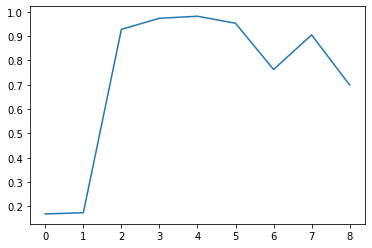

In [143]:
# Plot the accuracy for each dataset.

import matplotlib.pyplot as plt

overall_accuracy = [accuracy_f100,accuracy_f150,accuracy_f200,accuracy_f250,accuracy_f300,accuracy_f350,accuracy_f400,accuracy_f450,accuracy_f500]
plt.plot(overall_accuracy)

average_accuracy = ((accuracy_f100+accuracy_f150+accuracy_f200+accuracy_f250+accuracy_f300+accuracy_f350+accuracy_f400+accuracy_f450+accuracy_f500)/9)*100
print("The average accuracy of the model is " + str(average_accuracy) + "%")

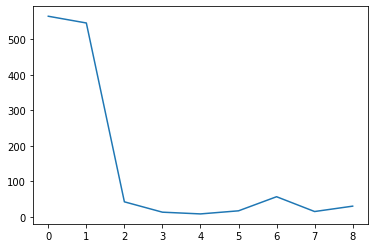

In [144]:
# Plot the error for each dataset.

overall_error = [error_f100,error_f150,error_f200,error_f250,error_f300,error_f350,error_f400,error_f450,error_f500]
plt.plot(overall_error)

The average accuracy of the model is 88.60141391242723%


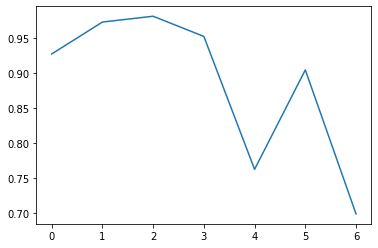

In [145]:
# Plot the accuracy for each dataset (without the problematic area, f100-f150).

overall_accuracy_2 = [accuracy_f200,accuracy_f250,accuracy_f300,accuracy_f350,accuracy_f400,accuracy_f450,accuracy_f500]
plt.plot(overall_accuracy_2)

average_accuracy_2 = ((accuracy_f200+accuracy_f250+accuracy_f300+accuracy_f350+accuracy_f400+accuracy_f450+accuracy_f500)/7)*100
print("The average accuracy of the model is " + str(average_accuracy_2) + "%")

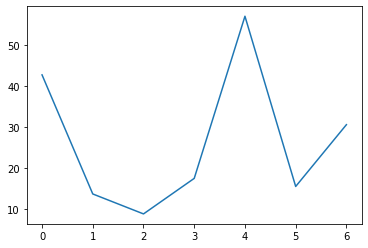

In [146]:
# Plot the error for each dataset (without the problematic area, f100-f150).

overall_error_2 = [error_f200,error_f250,error_f300,error_f350,error_f400,error_f450,error_f500]
plt.plot(overall_error_2)